In [1]:
#Import necessary Libaries and Function
%matplotlib nbagg 
import numpy as np
from ncempy.io.dm import fileDM  #package to load DM file
import matplotlib.pyplot as plt 
from skimage.restoration import unwrap_phase
from scipy.signal import fftconvolve
from skimage.filters import window
import empyre as emp
import hyperspy.api as hs

from time import time

#LiberTem-Holo Package
from libertem_holo.base.reconstr import (reconstruct_frame,
                                         get_slice_fft,
                                         estimate_sideband_position,
                                         estimate_sideband_size)
from libertem_holo.base.mask import disk_aperture, line_filter
from libertem_holo.base.filters import clipped, window_filter
from libertem_holo.base.registration import stackregistration

/Users/gunawan/.conda/envs/patricktrial/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [2]:
#Loading data from DM4 file
with fileDM ('/cachedata/users/gunawan/Holo_Stack_pi_2.dm3') as f:
    data_2 = f.getDataset(0)
with fileDM ('/cachedata/users/gunawan/Holo_Stack_pi_5.dm3') as f:
    data_5 = f.getDataset(0)
with fileDM ('/cachedata/users/gunawan/Simulated_holo_stack_pi_30.dm3') as f:
    data_30 = f.getDataset(0)
    
image_original_pi2 = data_2['data'] #the input data contain one stack of Images
image_original_pi5 = data_5['data'] #image reference for better reconstruction
image_original_pi30 = data_30['data'] #image reference for better reconstruction
number_of_images = len(image_original_pi2) #how many images in the stack

<IPython.core.display.Javascript object>


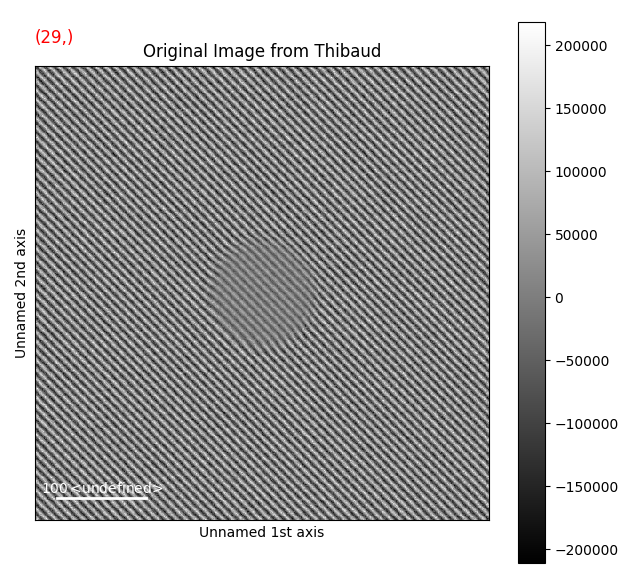

In [3]:
image_stack_original_pi30 = hs.signals.Signal2D(image_original_pi30,stack=True)
image_stack_original_pi30.plot(navigator='slider', 
                          vmax=float(np.max(clipped(image_original_pi30))),
                          title="Original Image from Thibaud")

In [4]:
#FT
image_FT = np.fft.ifft2(image_original_pi30[0])

<IPython.core.display.Javascript object>


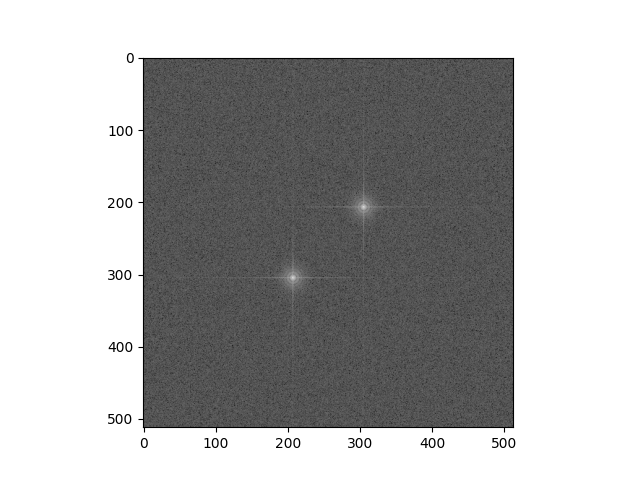

In [5]:
plt.figure()
plt.imshow(np.log1p(np.fft.fftshift(np.abs(image_FT))), cmap="gray")

In [6]:
sideband_lower_position = np.array((305,207))
sideband_upper_position = np.array((207,305))

In [7]:
angle_sidebands = np.arctan2(sideband_lower_position[0]-sideband_upper_position[0], 
                             sideband_lower_position[1]-sideband_upper_position[1])
angle_sidebands = angle_sidebands - (np.pi/2)
distance_sidebands = np.sqrt((sideband_lower_position[0]-sideband_upper_position[0])**2 + 
                     (sideband_lower_position[1]-sideband_upper_position[1])**2 )
fringe_space = 1/distance_sidebands

In [61]:
Tx = (fringe_space * 1000) * np.cos(angle_sidebands)
Ty = (fringe_space * 1000) * np.sin(angle_sidebands)

In [81]:
from skimage.draw import line
length = fringe_space *1000
start_pos = (505,7)
end_pos = (start_pos[0] - 4*(int(np.floor(length * np.sin(angle_sidebands)))),
           start_pos[1] + 4*(int(np.floor(length * np.cos(angle_sidebands)))))
rr, cc = line(start_pos[0], start_pos[1], end_pos[0], end_pos[1])
mask1 = np.zeros((512,512))
mask1[rr, cc] = 1

end_pos1 = (start_pos[0] - 4*(int(np.floor(Ty))),
           start_pos[1])
rr1, cc1 = line(start_pos[0], start_pos[1], end_pos1[0], end_pos1[1])
mask1[rr1, cc1] = 1

end_pos2 = (start_pos[0],
           start_pos[1] + 4*(int(np.floor(Tx))))
rr2, cc2 = line(start_pos[0], start_pos[1], end_pos2[0], end_pos2[1])
mask1[rr2, cc2] = 1

<IPython.core.display.Javascript object>


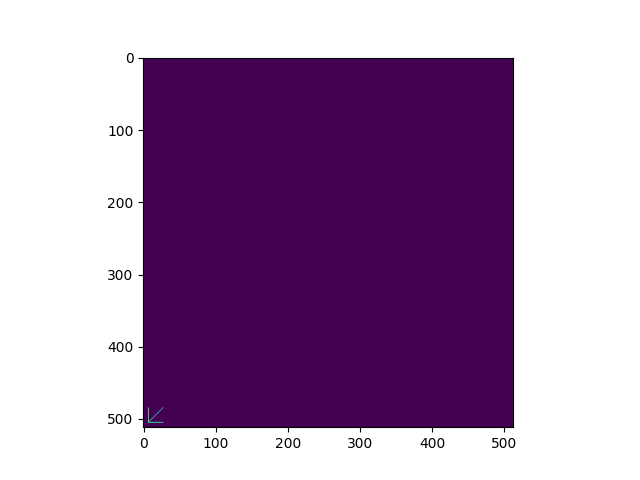

In [82]:
plt.figure()
plt.imshow(mask1)

<IPython.core.display.Javascript object>


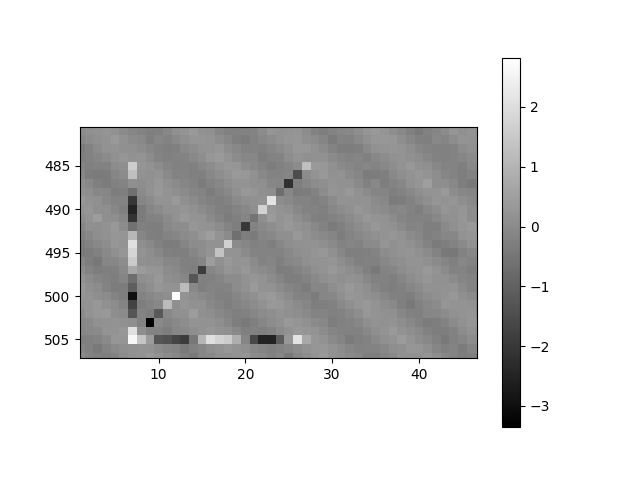

In [83]:
plt.figure()
plt.imshow((image_original_pi30[0]/np.max(image_original_pi30[0]))*(mask1*4+0.5), cmap="gray")
plt.colorbar()

In [13]:
Tx = (fringe_space * 1000) * np.cos(angle_sidebands)
Ty = (fringe_space * 1000) * np.sin(angle_sidebands)

In [14]:
fringe_space*1000, Tx,Ty

(7.215375318230077, 5.102040816326531, 5.1020408163265305)

In [15]:
from skimage.draw import line
length = distance_sidebands
start_pos = (305, 207)
end_pos = (start_pos[0] - int(np.floor(length * np.sin(angle_sidebands))),
           start_pos[1] + int(np.floor(length * np.cos(angle_sidebands))))

rr, cc = line(start_pos[0], start_pos[1], end_pos[0], end_pos[1])
mask = np.ones((512,512))
mask[rr, cc] = 0

<IPython.core.display.Javascript object>


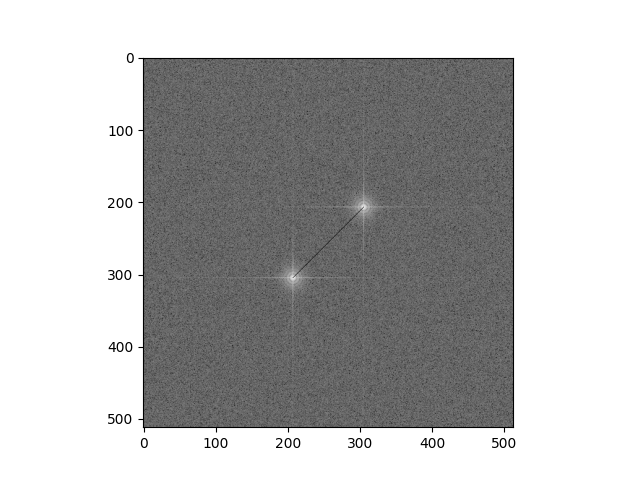

In [16]:
plt.figure()
plt.imshow(np.log1p(np.fft.fftshift(np.abs(image_FT)))*mask, cmap="gray")

In [17]:
n = np.arange(1,31)
N = 30
phi_initial = 2 * np.pi * n/N

In [50]:
c2 = 0
for i in range (len(n)-1):
    c2 = c2 + (image_original_pi30[i] * np.exp(-1j* phi_initial[i]))
c2 = c2 / N

<IPython.core.display.Javascript object>


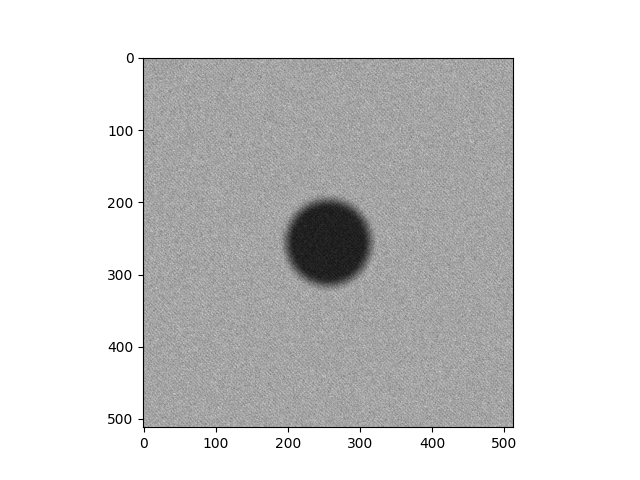

<IPython.core.display.Javascript object>


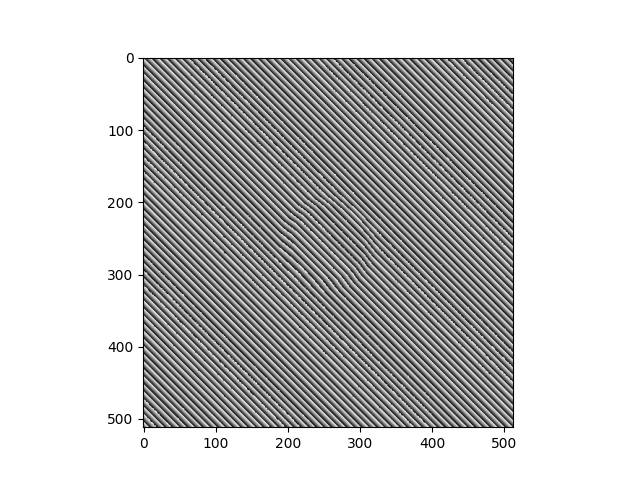

In [51]:
plt.figure()
plt.imshow(np.abs(c2), cmap="gray")
plt.figure()
plt.imshow(np.angle(c2), cmap="gray")

In [35]:
x = np.linspace(0, image_original_pi30[0].shape[1]-1, image_original_pi30[0].shape[1])
y = np.linspace(0, image_original_pi30[0].shape[0]-1, image_original_pi30[0].shape[0])
xv, yv = np.meshgrid(x,y, indexing='ij')

<IPython.core.display.Javascript object>


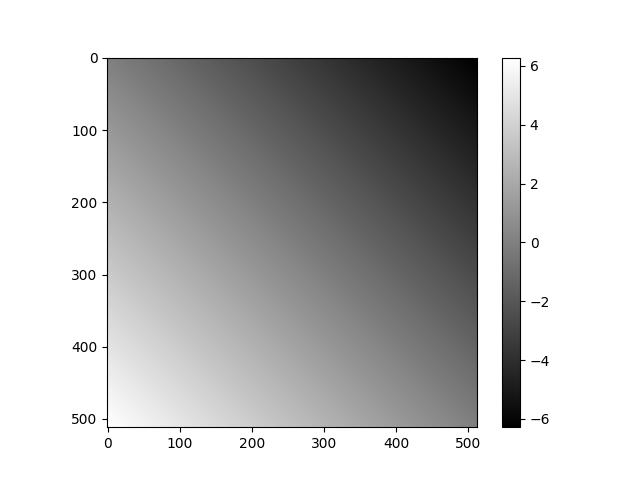

<IPython.core.display.Javascript object>


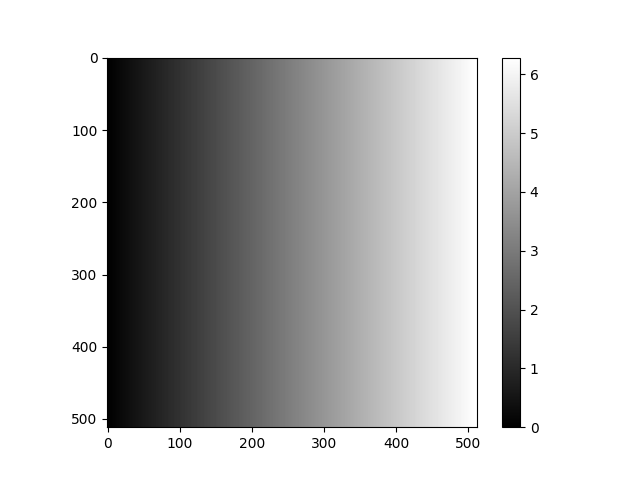

In [41]:
a = 2*np.pi*xv/Tx
b = 2*np.pi*yv/Ty
plt.figure()
plt.imshow(a-b, cmap="gray")
plt.colorbar()
plt.figure()
plt.imshow(b, cmap="gray")
plt.colorbar()

<IPython.core.display.Javascript object>


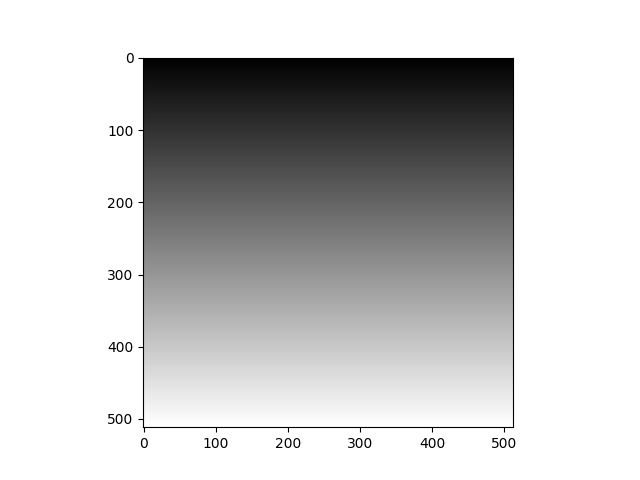

<IPython.core.display.Javascript object>


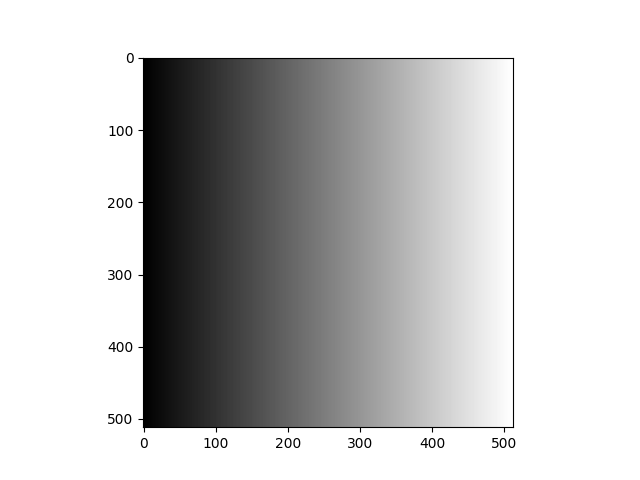

In [21]:

plt.figure()
plt.imshow(xv,cmap="gray")
plt.figure()
plt.imshow(yv,cmap="gray")

In [55]:
phase_distribution = np.arctan2(np.imag(c2), np.real(c2)) - a - b
phase_distribution1 = np.angle(c2) - a - b

In [60]:
phase_distribution.dtype

dtype('float64')

<IPython.core.display.Javascript object>


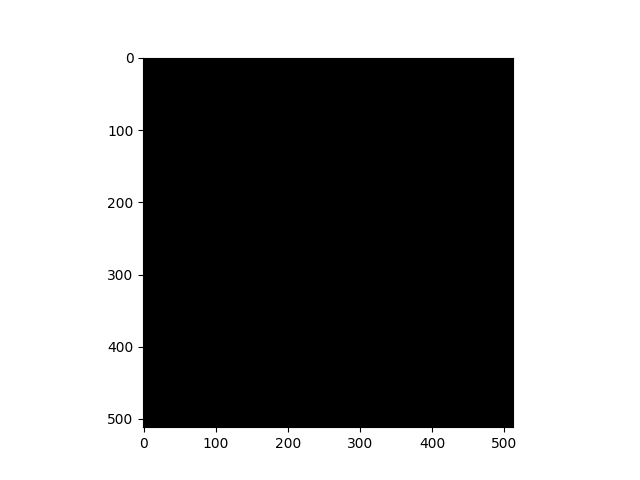

<IPython.core.display.Javascript object>


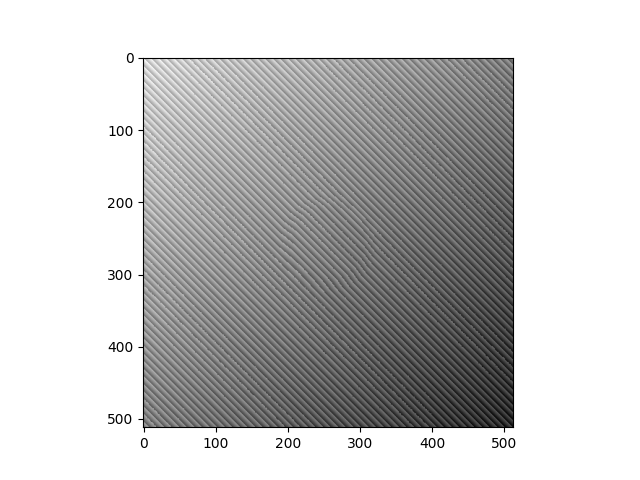

In [58]:
plt.figure()
plt.imshow(phase_distribution-phase_distribution1, cmap="gray")
plt.figure()
plt.imshow(phase_distribution1, cmap="gray")

In [45]:
from scipy.optimize import least_squares
def linear_gradient(c,dy,dx,y,x):
    return c+y*dy+x*dx
y = np.arange(0,512)
x = np.arange(0,512)

def fun(initial_value):
    function = image_not_compensated - linear_gradient(initial_value[0], initial_value[1], initial_value[2], yv, xv)
    return function.reshape((-1,))
yv,xv = np.meshgrid(y,x)

image_not_compensated = np.copy(phase_distribution)
m_initial = np.gradient(image_not_compensated)
dy_initial = np.mean(m_initial[0])
dx_initial = np.mean(m_initial[1])
c_initial = phase_distribution[511,0]
initial_value = np.array([c_initial,dy_initial,dx_initial])
res1 = least_squares(fun, initial_value)


In [46]:
dy_initial, dx_initial

(-0.012290841050360636, -0.012433525169927722)

In [47]:
gradient_compensation = linear_gradient(res1.x[0], res1.x[1], 
                                        res1.x[2], yv, xv) 
phase_distribution_compensated = phase_distribution - gradient_compensation

<IPython.core.display.Javascript object>


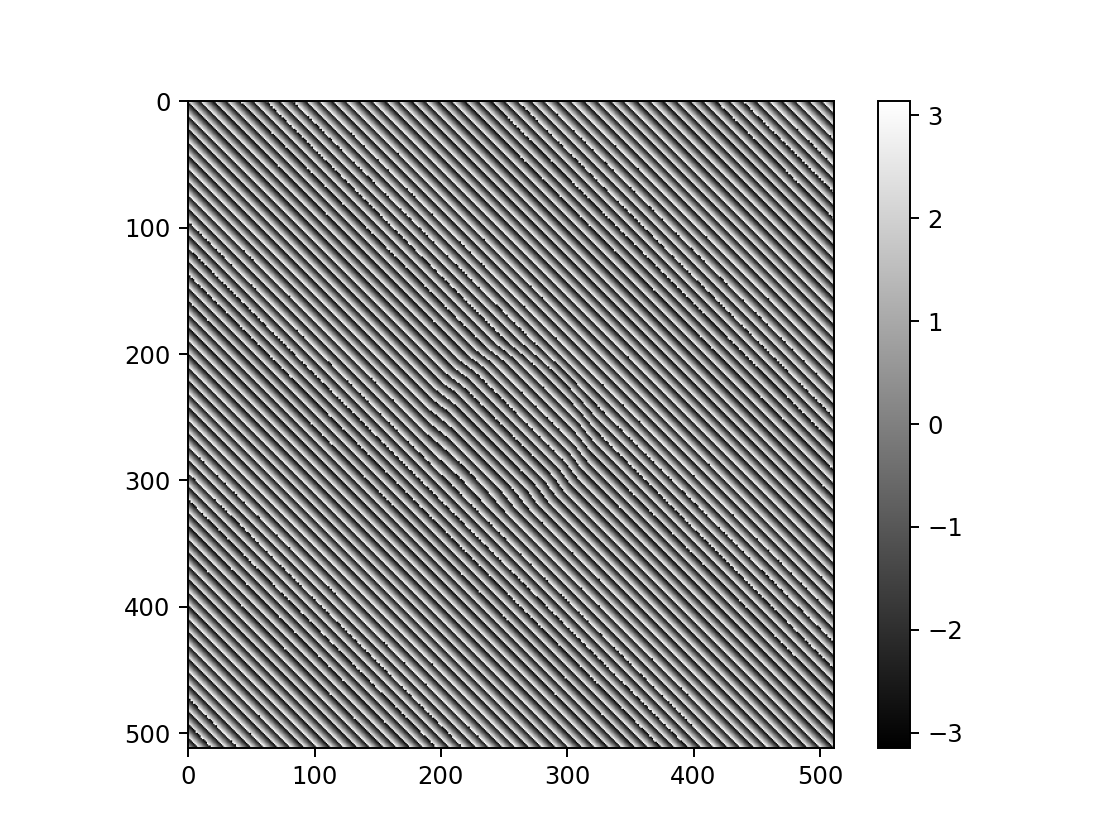

In [48]:
plt.figure()
plt.imshow(phase_distribution_compensated, cmap="gray")
plt.colorbar()

<IPython.core.display.Javascript object>


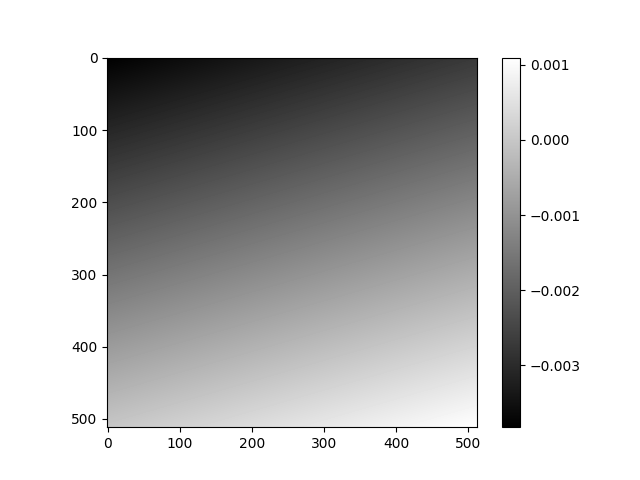

In [29]:
plt.figure()
plt.imshow(phase_distribution_compensated - np.angle(c2), cmap="gray")
plt.colorbar()

<IPython.core.display.Javascript object>


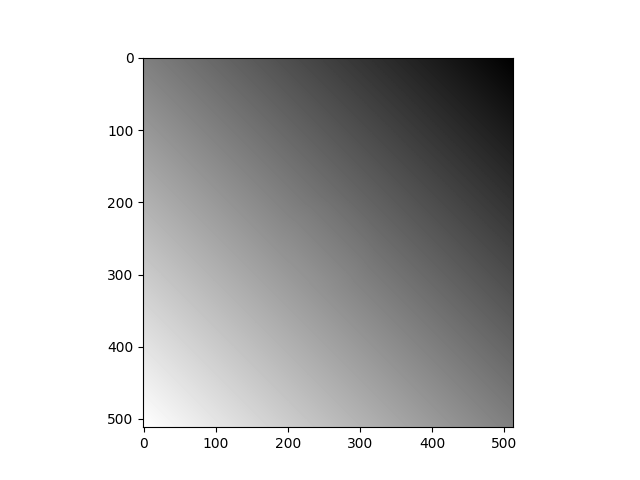

In [49]:
plt.figure()
plt.imshow(unwrap_phase(phase_distribution_compensated), cmap="gray")